## **Лабораторная работа №1: «Метод обратного распространения ошибки»**

**Цели работы:**

Изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой)

**Задачи работы:**

1. Изучить общую схему работы метода обратного распространения ошибки с использованием стохастического градиентного спуска.

2. Вывести математические формулы для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.

3. Загрузить набор данных MNIST, выполнить предобработку изображений и меток, если это необходимо.

4. Реализовать и протестировать метод обратного распространения ошибки для задачи классификации рукописных цифр из набора данных MNIST.

**Конфигурация нейронной сети:**

1. Входной слой содержит w x h нейронов, что соответствует разрешению одноканального изображения. Для набора MNIST — 28 x 28.

2. Выходной слой содержит k нейронов, что соответствует количеству классов изображений. Для задачи классификации рукописных цифр MNIST — 10 классов.

3. Скрытый слой содержит s нейронов (параметр).

4. Параметры метода обучения:
*   Скорость обучения (learning rate)
*   Размер пачки данных (batch_size)
*   Количество эпох

5. Функции активации:
*   На скрытом слое — функция ReLU
*   На выходном слое — функция Softmax
*   Входной слой не содержит функции активации.

6. Функция ошибки — кросс-энтропия.

7. Контрольные параметры:
*  Размер пачки: от 8 до 64 изображений
*  Скорость обучения: 0.1.
*  Количество скрытых нейронов s: 300
*  Количество эпох: 20.





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import struct
from array import array
from os.path  import join
import random

1. Вспомогательные функции

* ReLU — функция активации скрытого слоя
* ReLU derivative — производная функция для ReLU
* Softmax — функция активации выходного слоя
* Cross-entropy — функция ошибки
* Accuracy — точность предсказания

In [2]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_j = np.exp(x - np.max(x, axis = 1, keepdims=True))
    return exp_j / np.sum(exp_j, axis = 1, keepdims=True)

def cross_entropy(y, pred):
    return -np.mean(np.sum(y * np.log(pred), axis=1))

def accuracy(test, pred):
    return np.mean(np.argmax(pred, axis=1) == np.argmax(test, axis=1))

2. Реализация метода обратного распространения ошибки

In [3]:
class BackPropagation:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Инициализация синаптических весов для скрытого и входных слоев
        he_weight_init = np.sqrt(2 / input_size)
        self.hidden_weight = np.random.randn(self.input_size, self.hidden_size) * he_weight_init
        self.output_weight = np.random.randn(self.hidden_size, self.output_size) * he_weight_init

        # Инициализация смещений для скрытого и выходного слоев
        self.hidden_bias = np.zeros((1, self.hidden_size))
        self.output_bias = np.zeros((1, self.output_size))

    # Прямой проход
    def forward(self, X):
        self.hidden_layer = np.dot(X, self.hidden_weight) + self.hidden_bias
        self.relu_activation = relu(self.hidden_layer)
        self.output_layer = np.dot(self.relu_activation, self.output_weight) + self.output_bias
        self.softmax_activation = softmax(self.output_layer)
        return self.softmax_activation

    # Обратный проход
    def backward(self, X, y, learning_rate):
        self.prediction = self.forward(X)

        # Вычисление производных по весам и смещениям
        self.dError_doutput = self.prediction - y
        self.dError_doutput /= len(y)
        self.dError_doutput_weight = np.dot(self.relu_activation.T, self.dError_doutput)
        self.dError_doutput_bias = np.sum(self.dError_doutput, axis=0)
        self.dError_dhidden = np.dot(self.dError_doutput, self.output_weight.T)
        self.dError_dhidden_weight = np.dot(X.T, self.dError_dhidden * relu_derivative(self.hidden_layer))
        self.dError_dhidden_bias = np.sum(self.dError_dhidden * relu_derivative(self.hidden_layer), axis=0)

        # Корректировка весов
        self.hidden_weight -= learning_rate * self.dError_dhidden_weight
        self.hidden_bias -= learning_rate * self.dError_dhidden_bias
        self.output_weight -= learning_rate * self.dError_doutput_weight
        self.output_bias -= learning_rate * self.dError_doutput_bias

    # Обучение
    def train(self, x_train, y_train, epochs, learning_rate, batch_size):
        common_time_start = time.time()
        for epoch in range(epochs):
            start_time = time.time()
            shuffle_indexes = np.arange(len(x_train))
            np.random.shuffle(shuffle_indexes)
            x_train = x_train[shuffle_indexes]
            y_train = y_train[shuffle_indexes]

            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i : i + batch_size]
                y_batch = y_train[i : i + batch_size]
                self.backward(x_batch, y_batch, learning_rate)

            time_stop = time.time() - start_time

            predictions = self.forward(x_train)
            loss = cross_entropy(y_train, predictions)
            accur = accuracy(y_train, predictions)

            print(f"Эпоха: {epoch + 1}/20")
            print(f"    Время: {time_stop}\n    Потери: {loss}\n    Точность: {accur}")
        common_time = time.time() - common_time_start
        print("Обучение закончено!")
        print(f"Общее время обучения: {common_time}")

    # Тестирование
    def test(self, x_test, y_test):
        test_time_start = time.time()
        test_predictions = self.forward(x_test)
        test_time = time.time() - test_time_start
        test_accuracy = accuracy(y_test, test_predictions)
        test_loss = cross_entropy(y_test, test_predictions)
        print("Тестирование завершено!")
        print(f"Точность на тестовом наборе: {test_accuracy}")
        print(f"Потери на тестовом наборе: {test_loss}")
        print(f"Время тестирования: {test_time}")

3. Загрузка набора данных **MNIST**

In [4]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [5]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

In [6]:
input_path = '/content/drive/MyDrive/mnist/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print("Размер тренировочных данных")
print("x_train = ", x_train.shape)
print("y_train = ", y_train.shape)
print("Размер тестовых данных")
print("x_test = ", x_test.shape)
print("y_test = ", y_test.shape)


Размер тренировочных данных
x_train =  (60000, 28, 28)
y_train =  (60000,)
Размер тестовых данных
x_test =  (10000, 28, 28)
y_test =  (10000,)


4. Демонстрация изображений и меток

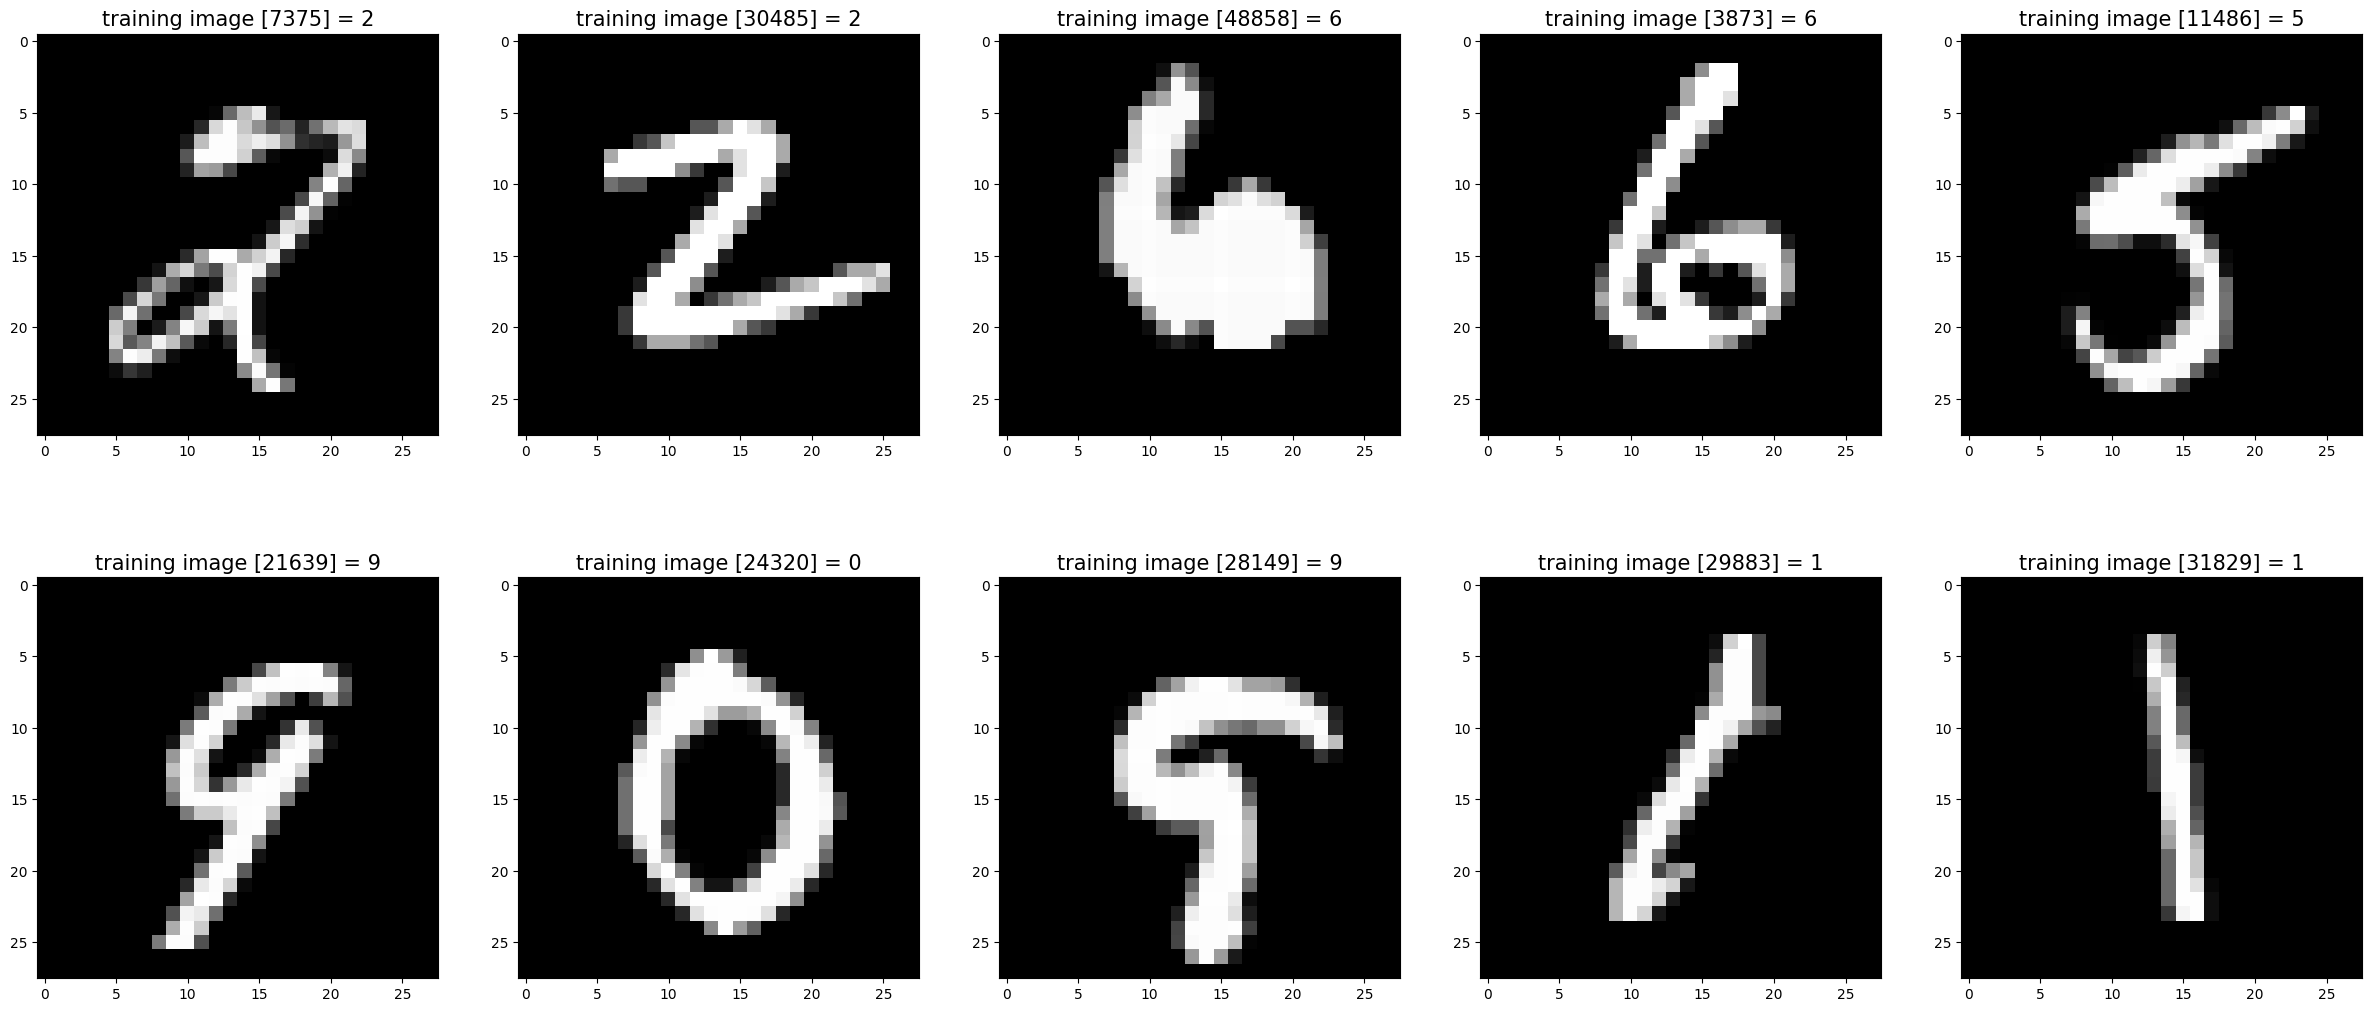

In [7]:
train_images_2_show = []
train_titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    train_images_2_show.append(x_train[r])
    train_titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

show_images(train_images_2_show, train_titles_2_show)

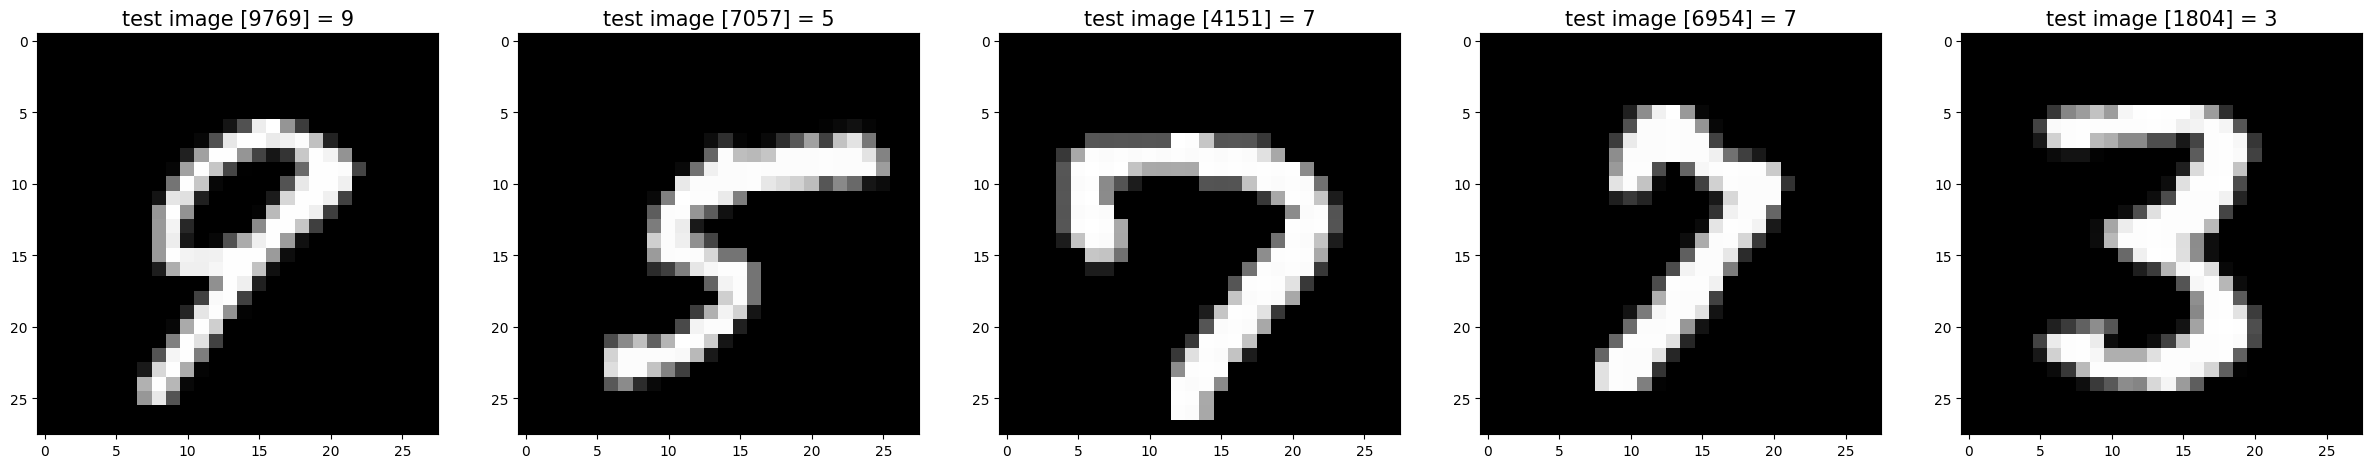

In [8]:
test_images_2_show = []
test_titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 10000)
    test_images_2_show.append(x_test[r])
    test_titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(test_images_2_show, test_titles_2_show)

5. Задание параметров

In [9]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
learning_rate = 0.1
epochs = 20
batch_size = 64

6. Предобработка изображений

In [10]:
x_train = x_train.reshape([-1, input_size]) / 255.0
x_test = x_test.reshape([-1, input_size]) / 255.0

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]


7. Обучение

In [11]:
net = BackPropagation(input_size, hidden_size, output_size)
net.train(x_train, y_train, epochs, learning_rate, batch_size)

Эпоха: 1/20
    Время: 5.1543097496032715
    Потери: 0.2407509863106712
    Точность: 0.9336333333333333
Эпоха: 2/20
    Время: 2.8496437072753906
    Потери: 0.16716100020036045
    Точность: 0.9530833333333333
Эпоха: 3/20
    Время: 6.25600528717041
    Потери: 0.133690919091269
    Точность: 0.9631166666666666
Эпоха: 4/20
    Время: 2.8608031272888184
    Потери: 0.1003605294263823
    Точность: 0.9729166666666667
Эпоха: 5/20
    Время: 2.809272289276123
    Потери: 0.08317184115193804
    Точность: 0.9775
Эпоха: 6/20
    Время: 6.037580490112305
    Потери: 0.07146985688550694
    Точность: 0.9809
Эпоха: 7/20
    Время: 2.945457696914673
    Потери: 0.06330500542442498
    Точность: 0.9833166666666666
Эпоха: 8/20
    Время: 2.8548121452331543
    Потери: 0.055128196253509745
    Точность: 0.9854
Эпоха: 9/20
    Время: 5.476715564727783
    Потери: 0.04695718565744565
    Точность: 0.9882166666666666
Эпоха: 10/20
    Время: 2.861318588256836
    Потери: 0.041737233801174216
    Точ

8. Тестирование

In [12]:
net.test(x_test, y_test)

Тестирование завершено!
Точность на тестовом наборе: 0.9804
Потери на тестовом наборе: 0.060571549281354
Время тестирования: 0.12822198867797852
